In [1]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

img = cv2.imread('../images/sakura.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

(-0.5, 1079.5, 601.5, -0.5)

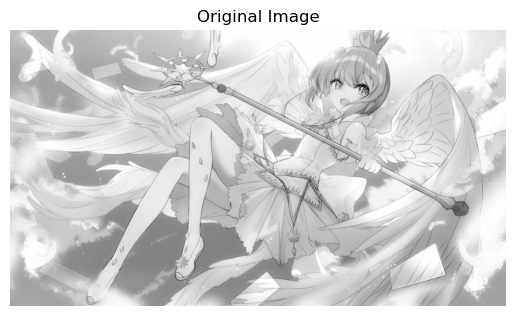

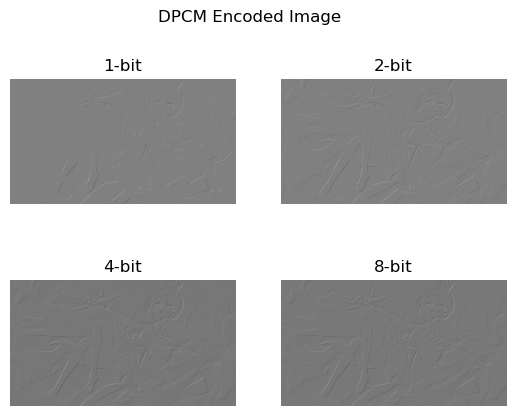

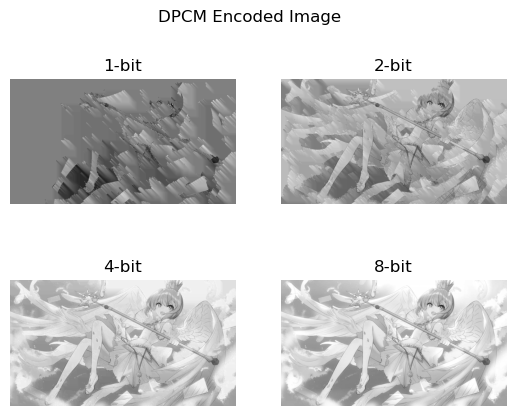

In [2]:
# DPCM编码
def dpcm_encode(image, quantization_factor):
    # 初始化差值图像，需要为有符号数，表示两个uint8数组的差值的数据需要大于8位
    diff_image = np.zeros_like(image, dtype=np.int16)
    # 初始化预测像素，predicted_pixel与diff_image间存在运算，设置uint8会出错
    predicted_pixel = np.zeros_like(image, dtype=np.int16)
    # 量化参数为1时，代表将8位的差值(二进制表示)右移7位，只取1位有效位，在十进制下表示为除以2^7，同理可以推出其他情况的除数。此时损失了精度，但不改变大小。
    devide_quantization_factor = 2 ** (8 - quantization_factor)
    # 对每个像素进行编码
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            # 预测像素为左上角的像素
            if i == 0 and j == 0:
                # 128为初始值
                predicted_pixel[i, j] = 128
                diff_image[i, j] = image[i, j] - predicted_pixel[i, j]
                diff_image[i, j]  = (diff_image[i, j]  // devide_quantization_factor) * devide_quantization_factor 
            # 预测像素为左侧的像素
            elif i == 0:
                predicted_pixel[i, j] = predicted_pixel[i, j-1] + diff_image[i, j-1]
                diff_image[i, j]  = image[i, j] - predicted_pixel[i, j]
                diff_image[i, j]  = (diff_image[i, j]  // devide_quantization_factor) * devide_quantization_factor
            # 预测像素为上方的像素
            elif j == 0:
                predicted_pixel[i, j] = predicted_pixel[i-1, j] + diff_image[i-1, j]
                diff_image[i, j]  = image[i, j] - predicted_pixel[i, j]
                diff_image[i, j]  = (diff_image[i, j]  // devide_quantization_factor) * devide_quantization_factor
            # 预测像素为左上角、左侧和上方像素的平均值
            else:
                predicted_pixel[i, j] = (predicted_pixel[i-1, j] + predicted_pixel[i, j-1] + predicted_pixel[i-1, j-1] + diff_image[i-1, j] + diff_image[i, j-1] + diff_image[i-1, j-1]) // 3
                diff_image[i, j] = image[i, j] - predicted_pixel[i, j]
                diff_image[i, j] = (diff_image[i, j]  // devide_quantization_factor) * devide_quantization_factor
    
    return diff_image
    

# DPCM解码
def dpcm_decode(diff_image):
    # 初始化预测像素，数据格式设置为uint16可以防止运算过程溢出
    decoded_image = np.zeros_like(diff_image, dtype=np.int16)
    # 对每个像素进行解码
    for i in range(diff_image.shape[0]):
        for j in range(diff_image.shape[1]):
            # 预测像素为左上角的像素
            if i == 0 and j == 0:
                decoded_image[i, j] = 128 + diff_image[i, j]
            # 预测像素为左侧的像素
            elif i == 0:
                decoded_image[i, j] = decoded_image[i, j-1] + diff_image[i, j]
            # 预测像素为上方的像素
            elif j == 0:
                decoded_image[i, j] = decoded_image[i-1, j] + diff_image[i, j]
            # 预测像素为左上角、左侧和上方像素的平均值
            else:
                decoded_image[i, j] = (decoded_image[i-1, j] + decoded_image[i, j-1] + decoded_image[i-1, j-1]) // 3 + diff_image[i, j]
    decoded_image = decoded_image.astype(np.uint8)
    return decoded_image

# 设置量化因子, 单位为比特
# 将灰度图像进行DPCM编码与解码
# 1-bit 量化器
quantization_factor_1 = 1
diff_image_1 = dpcm_encode(gray, quantization_factor_1)
decoded_image_1 = dpcm_decode(diff_image_1)

# 2-bit
quantization_factor_2 = 2
diff_image_2 = dpcm_encode(gray, quantization_factor_2)
decoded_image_2 = dpcm_decode(diff_image_2)

# 4-bit
quantization_factor_3 = 4
diff_image_3 = dpcm_encode(gray, quantization_factor_3)
decoded_image_3 = dpcm_decode(diff_image_3)

# 8-bit
quantization_factor_4 = 8
diff_image_4 = dpcm_encode(gray, quantization_factor_4)
decoded_image_4 = dpcm_decode(diff_image_4)

figure1 = plt.figure()
plt.imshow(gray, cmap='gray')
plt.title('Original Image')
plt.axis('off')

figure2 = plt.figure()
figure2.suptitle('DPCM Encoded Image')
plt.subplot(2, 2, 1)
plt.imshow(diff_image_1, cmap='gray')
plt.title('1-bit')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(diff_image_2, cmap='gray')
plt.title('2-bit')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(diff_image_3, cmap='gray')
plt.title('4-bit')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(diff_image_4, cmap='gray')
plt.title('8-bit')
plt.axis('off')

figure3 = plt.figure()
figure3.suptitle('DPCM Encoded Image')
plt.subplot(2, 2, 1)
plt.imshow(decoded_image_1, cmap='gray')
plt.title('1-bit')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(decoded_image_2, cmap='gray')
plt.title('2-bit')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(decoded_image_3, cmap='gray')
plt.title('4-bit')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(decoded_image_4, cmap='gray')
plt.title('8-bit')
plt.axis('off')


In [3]:
from skimage.metrics import peak_signal_noise_ratio
from skimage.metrics import structural_similarity
# PSNR 和 SSIM 计算
PSNR1 = peak_signal_noise_ratio(gray, decoded_image_1)
SSIM1 = structural_similarity(gray, decoded_image_1)
print('1-bit\t',PSNR1, SSIM1)

PSNR2 = peak_signal_noise_ratio(gray, decoded_image_2)
SSIM2 = structural_similarity(gray, decoded_image_2)
print('2-bit\t',PSNR2, SSIM2)

PSNR3 = peak_signal_noise_ratio(gray, decoded_image_3)
SSIM3 = structural_similarity(gray, decoded_image_3)
print('4-bit\t',PSNR3, SSIM3)

PSNR4 = peak_signal_noise_ratio(gray, decoded_image_4)
SSIM4 = structural_similarity(gray, decoded_image_4)
print('8-bit\t',PSNR4, SSIM4)

1-bit	 9.117442689362473 0.5020491478366577
2-bit	 15.565768292039348 0.7031320018449323
4-bit	 28.504767414610534 0.9330104481695346
8-bit	 inf 1.0


c:\Users\lenovo\anaconda3\envs\myenv\lib\site-packages\skimage\metrics\simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


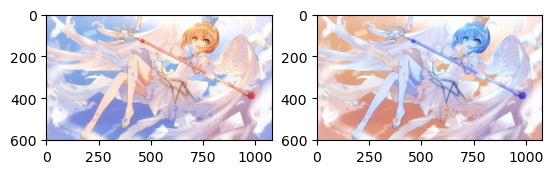

In [4]:
# plt.imshow图像需要为RGB通道， 而cv2.imread读出的图像为BGR通道
img2 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.subplot(121)
plt.imshow(img2)
plt.subplot(122)
plt.imshow(img)